# Structure 

* ### [Device Set Up](#device)
* ### [Utils](#utils_funcs)
* ### [MNIST Dataset](#mnist_dataset)
* ### [CIFAR-10 Dataset](#cifar10_dataset)

In [323]:
import numpy as np
import os

from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

### <a id='device'>Device Set up</a>

##### MacOS Apple Silicon GPU

In [324]:
# Connect GPU
device = torch.device("mps")

##### Google Colab GPU

In [325]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### <a id='utils_funcs'> Utils </a>

In [326]:
# Seed
def set_seed(seed):
    """
    The function that sets a random seed to ensure the reproducibility of any randomized processes
    """

    np.random.seed(seed)
    torch.manual_seed(seed)

In [327]:
# Model Class
class CNN(nn.Module):
    """
    Convolutional Neural Network
    """

    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()


        self.conv1 = nn.Sequential(nn.Conv2d(in_dim, 16, kernel_size = 5, stride = 1, padding = 2),
                                   nn.BatchNorm2d(16),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(kernel_size = 2))

        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2),
                                   nn.BatchNorm2d(32),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(kernel_size = 2))

        self.fc_output = nn.Sequential(nn.Linear(32 * 8 * 8, out_dim))

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'leaky_relu')

                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)


    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        output = self.fc_output(x2.view(x2.size(0), -1))

        return output

In [328]:
# Model Trainer Class

class FCNNTrainer:
    def __init__(self, lr: int, model: nn.Module, device):
        set_seed(9)

        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.optimizer_name = None
        self.optimizer = None
        self.lr = lr
        self.epochs = None
        self.train_loader = None
        self.test_loader = None
        self.train_metrics = []
        self.test_metrics = []
        self.models_dir = "./models_states"


    def set_optimizer(self, optimizer_name: str, optimizer_func):
        self.optimizer = optimizer_func(self.model.parameters(), lr=self.lr)
        self.optimizer_name = optimizer_name

    def set_epochs(self, epochs: int):
        self.epochs = epochs

    def prepare_loaders(self, train_dataset, test_dataset, batch_size: int) -> dict:
        train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
        test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

        self.train_loader = train_loader
        self.test_loader = test_loader

        return {
            "train": train_loader,
            "test": test_loader
        }

    def __optimize_weights(self) -> float:
        self.model.train()
        total_loss = 0
        for x_tr, y_tr in self.train_loader:
            x_tr, y_tr = x_tr.to(self.device), y_tr.to(self.device)
            outputs = self.model(x_tr)
            loss = self.criterion(outputs, y_tr)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def __count_test_loss(self) -> float:
        self.model.eval()
        total_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for x_ts, y_ts in self.test_loader:
                x_ts, y_ts = x_ts.to(self.device), y_ts.to(self.device)
                outputs = self.model(x_ts)
                loss = self.criterion(outputs, y_ts)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += y_ts.size(0)
                correct += (predicted == y_ts).sum().item()

        accuracy = correct / total
        return total_loss / len(self.test_loader), accuracy

    def epoch_train(self, epoch_val: int, prev_epochs: int, benchmark_accuracy: float):
        best_accuracy = 0.0
        for epoch in range(epoch_val):
            train_loss = self.__optimize_weights()
            self.train_metrics.append(train_loss)

            test_loss, accuracy = self.__count_test_loss()
            self.test_metrics.append(test_loss)

            self.__save_parameters(epoch=epoch, prev_epochs=prev_epochs,
                                   model_name=f"{self.model.__class__.__name__}_{self.optimizer_name}")

            print(f'Train Epoch: {epoch} \t [Train Loss]: {train_loss:.6f} \t [Test Loss]: {test_loss:.6f} \t [Accuracy]: {accuracy:.4f}')

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                if best_accuracy >= benchmark_accuracy:
                    print(f"Reached {benchmark_accuracy}% accuracy at epoch {epoch + 1}")
                    return epoch + 1


    def plot_metrics(self, epochs: int):
        plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.train_metrics, label='Training Loss')
        plt.plot(range(epochs), self.test_metrics, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Cross')
        plt.title(f"Training and Validation CEL over Epochs via {self.optimizer_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def __save_parameters(self, epoch: int, prev_epochs: int, model_name: str):
        save_path = f'{self.models_dir}/{model_name}/epoch_{epoch + prev_epochs + 1}.pth'

        if not os.path.exists(f'{self.models_dir}/{model_name}'):
            os.makedirs(f'{self.models_dir}/{model_name}')

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': self.train_metrics[epoch + prev_epochs],
            'test_loss': self.test_metrics[epoch + prev_epochs],
        }, save_path)

        if not os.path.exists(save_path):
            raise IOError(f"Failed to save the model at {save_path}")
        
    
    def clear_main_values(self, model, device):
        self.model = model
        self.optimizer_name = None
        self.optimizer = None
        self.epochs = None
        self.train_metrics = []
        self.test_metrics = []

In [329]:
# Model Train Cycle Func

optimizers_list = {
    "Adam": torch.optim.Adam,
}

def train(
              model_class: nn.Module,
              in_dim: int,
              epochs_list: list,
              learning_rate: float,
              train_dataset,
              test_dataset,
              batch_size: int,
              benchmark_accuracy: float
        ) -> dict:
    # Init model
    model = model_class(in_dim, 10).to(device)
    # Init model trainder
    trainer = FCNNTrainer(lr=learning_rate, model=model, device=device)
    # Prepare 
    trainer.prepare_loaders(train_dataset, test_dataset, batch_size)
    best_parameters = {}

    for optimizer_name, optimizer_func in optimizers_list.items():
            trainer.set_optimizer(optimizer_name, optimizer_func)

            # Start training
            for ind, epoch in enumerate(epochs_list):
                    trainer.set_epochs(epoch)
                    success_epoch = trainer.epoch_train(epoch_val=epoch, prev_epochs=sum(epochs_list[:ind]), benchmark_accuracy=benchmark_accuracy)

                    trainer.plot_metrics(epochs=success_epoch)

            best_epoch = trainer.test_metrics.index(min(trainer.test_metrics))
            best_epoch += 1 ## Since we count from 0
            best_parameters[optimizer_name] = {"epoch": best_epoch, "min_loss": min(trainer.test_metrics)}
            model = model_class(in_dim, 10)
            trainer.clear_main_values(model, device)
    del trainer, model
    return best_parameters

In [330]:
# Model Test Func

def test_model(model: nn.Module, train_dataset, test_dataset):
    model.eval()
    train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=True)

    with torch.no_grad():
        ### Training dataset ###
        correct, total = 0, 0
        all_preds_tr, all_labels_tr = [], []

        for x_tr, y_tr in train_loader:
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            y_pred_tr = torch.softmax(model(x_tr), dim=1)
            # retrieve class with the highest probability
            y_pred_tr_class = torch.argmax(y_pred_tr, dim=1)

            correct += (y_pred_tr_class == y_tr).sum().item()
            total += y_tr.size(0)
            
            all_preds_tr.extend(y_pred_tr_class.cpu().numpy())
            all_labels_tr.extend(y_tr.cpu().numpy())

        train_acc = correct / total
        print(f'train_accuracy = {train_acc:.4f}')

        labels = np.sort(np.unique(all_labels_tr))
        conf_mtrx = confusion_matrix(all_labels_tr, all_preds_tr, labels=labels)
        cm_plot = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=labels)
        cm_plot.plot()
        plt.title('Confusion Matrix - Training')
        plt.show()

        ### Test dataset ###
        correct, total = 0, 0
        all_preds_ts, all_labels_ts = [], []

        for x_ts, y_ts in test_loader:
            x_ts, y_ts = x_ts.to(device), y_ts.to(device)
            y_pred_ts = torch.softmax(model(x_ts), dim=1)
            # retrieve class with the highest probability
            y_pred_ts_class = torch.argmax(y_pred_ts, dim=1)

            correct += (y_pred_ts_class == y_ts).sum().item()
            total += y_ts.size(0)

            all_preds_ts.extend(y_pred_ts_class.cpu().numpy())
            all_labels_ts.extend(y_ts.cpu().numpy())

        test_acc = correct / total
        print(f'test_accuracy = {test_acc:.4f}')

        labels = np.sort(np.unique(all_labels_ts))
        conf_mtrx = confusion_matrix(all_labels_ts, all_preds_ts, labels=labels)
        cm_plot = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=labels)
        cm_plot.plot()
        plt.title('Confusion Matrix - Test')
        plt.show()


In [331]:
# Loaders of best model state

def load_model_state(model: nn.Module, optimizer, optimizer_name: str, epoch: int, model_states_dir="./models_states"):
    model_name = f"{model.__class__.__name__}_{optimizer_name}"
    checkpoint_path = f'{model_states_dir}/{model_name}/epoch_{epoch}.pth'
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']


def load_best_model(epoch: int, optimizer_name: str, model: nn.Module, in_dim: int, lr: float):
    
    best_model = model(in_dim, 10).to(device)
    optimizer = optimizers_list[optimizer_name](best_model.parameters(), lr=lr)
    load_model_state(best_model, optimizer, optimizer_name, epoch)
    return best_model, optimizer

### <a id='mnist_dataset'> MNIST Dataset </a>

Train Epoch: 0 	 [Train Loss]: 0.222132 	 [Test Loss]: 0.065870 	 [Accuracy]: 0.9813
Train Epoch: 1 	 [Train Loss]: 0.060776 	 [Test Loss]: 0.048365 	 [Accuracy]: 0.9843
Train Epoch: 2 	 [Train Loss]: 0.045074 	 [Test Loss]: 0.047582 	 [Accuracy]: 0.9846
Train Epoch: 3 	 [Train Loss]: 0.037530 	 [Test Loss]: 0.034478 	 [Accuracy]: 0.9872
Train Epoch: 4 	 [Train Loss]: 0.032087 	 [Test Loss]: 0.033313 	 [Accuracy]: 0.9888
Train Epoch: 5 	 [Train Loss]: 0.027593 	 [Test Loss]: 0.032759 	 [Accuracy]: 0.9888
Train Epoch: 6 	 [Train Loss]: 0.023781 	 [Test Loss]: 0.032576 	 [Accuracy]: 0.9896
Train Epoch: 7 	 [Train Loss]: 0.021106 	 [Test Loss]: 0.029042 	 [Accuracy]: 0.9900
Reached 0.99% accuracy at epoch 8


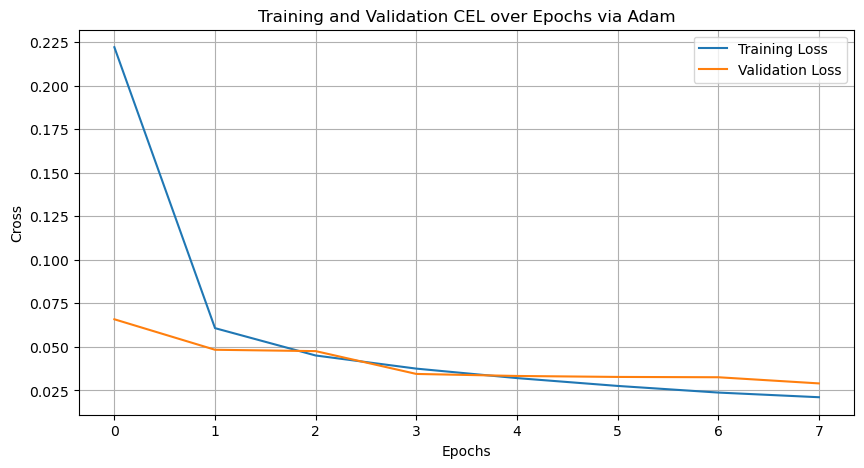

In [342]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5)),
                                      transforms.Resize((32, 32))])


# transformation are applied dynamically on the retrieval of individual items
train_dataset = datasets.MNIST(root = './data', train = True, transform = mnist_transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = mnist_transform, download = True)


in_dim = 1
lrs = np.logspace(-4, 0, num=10, base=10)
epochs = [11]
model_class = CNN

# Empirically discovered: batch size decreased to 80 for frequent updates, since with big batch size I've got really bad results and too small weights updates
best_parameters_list = []
for lr in lrs[1:2]: # empirically discovered that learning rate value 0.001 provides sufficient results
    best_parameters = train(
        model_class=model_class,
        in_dim=in_dim,
        epochs_list=epochs,
        learning_rate=lr,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        batch_size=80,
        benchmark_accuracy=0.99
    )
    best_parameters_list.append(best_parameters)

In [343]:
for best in best_parameters_list:
    print(best)

{'Adam': {'epoch': 8, 'min_loss': 0.0290419561304152}}


In [344]:
best_parameters = best_parameters_list[0]
print(best_parameters)
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
model,_ = load_best_model(
    epochs,
    optimizer_name,
    model_class,
    in_dim,
    lr
)

{'Adam': {'epoch': 8, 'min_loss': 0.0290419561304152}}


train_accuracy = 0.9958


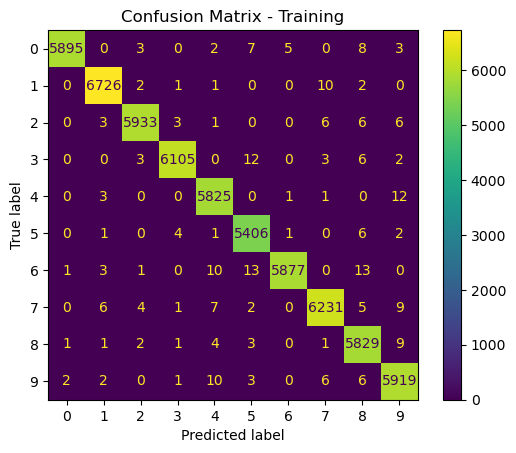

test_accuracy = 0.9900


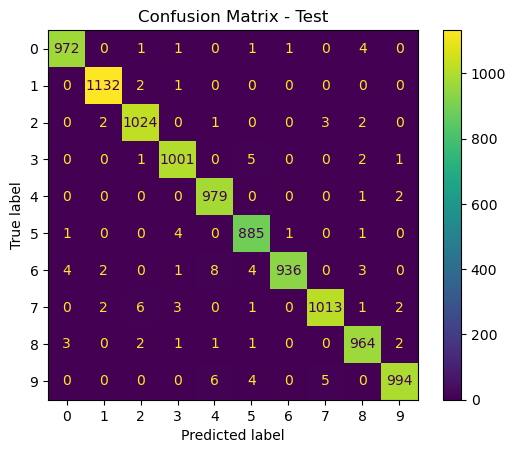

In [345]:
test_model(model, train_dataset, test_dataset)

### <a id='cifar10_dataset'> CIFAR-10 Dataset </a>

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 	 [Train Loss]: 1.399051 	 [Test Loss]: 1.176221 	 [Accuracy]: 0.5830
Train Epoch: 1 	 [Train Loss]: 1.082029 	 [Test Loss]: 1.081526 	 [Accuracy]: 0.6246
Train Epoch: 2 	 [Train Loss]: 0.970772 	 [Test Loss]: 0.969751 	 [Accuracy]: 0.6662
Train Epoch: 3 	 [Train Loss]: 0.908260 	 [Test Loss]: 0.962431 	 [Accuracy]: 0.6707
Train Epoch: 4 	 [Train Loss]: 0.855774 	 [Test Loss]: 0.921629 	 [Accuracy]: 0.6871
Reached 0.68% accuracy at epoch 5


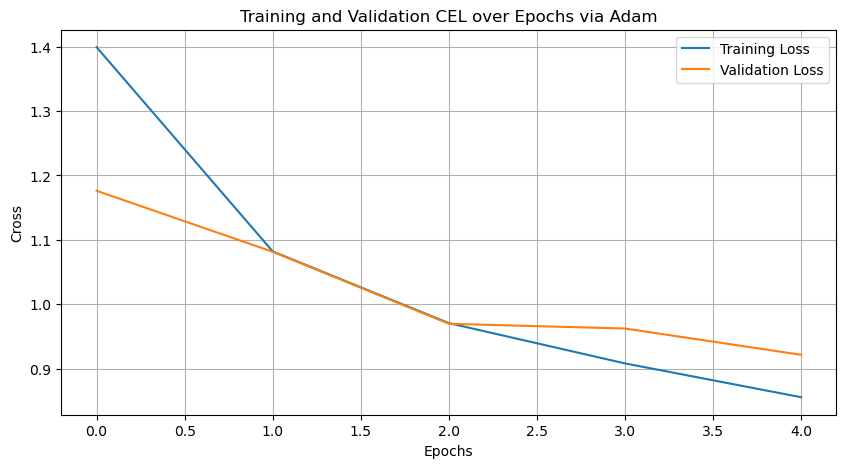

In [339]:
cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# transformation are applied dynamically on the retrieval of individual items
train_dataset = datasets.CIFAR10(root = './data', train = True, transform = cifar10_transform, download = True)
test_dataset = datasets.CIFAR10(root = './data', train = False, transform = cifar10_transform, download = True)

in_dim = 3
lrs = np.logspace(-4, 0, num=10, base=10)
epochs = [11]
model_class = CNN

# Empirically discovered: batch size decreased to 50 for frequent updates, since with batch size I've got really bad results and too fast learning
# This dataset size is smaller than MNIST, so I decided right away to take smaller batch size
best_parameters_list = []
for lr in lrs[1:2]: # empirically discovered that learning rate value 0.001 provides sufficient results
    best_parameters = train(
        model_class=model_class,
        in_dim=in_dim,
        epochs_list=epochs,
        learning_rate=lr,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        batch_size=40,
        benchmark_accuracy=0.68
    )
    best_parameters_list.append(best_parameters)

{'Adam': {'epoch': 5, 'min_loss': 0.9216286313533782}}
train_accuracy = 0.7238


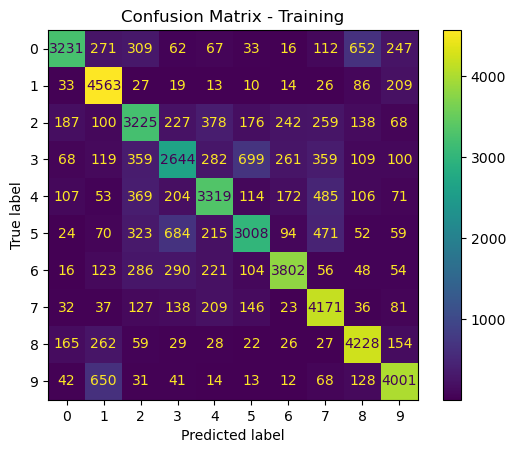

test_accuracy = 0.6871


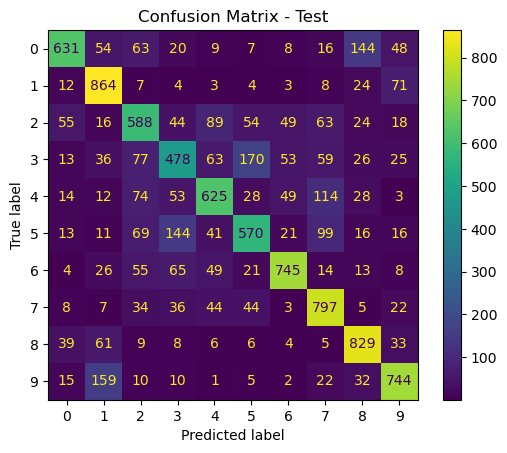

In [341]:
best_parameters = best_parameters_list[0]
print(best_parameters)
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
model,_ = load_best_model(
    epochs,
    optimizer_name,
    model_class,
    in_dim,
    lr
)
test_model(model, train_dataset, test_dataset)